# Training data is generated from CoolProp.

In [ ]:
import numpy as np
from sklearn import preprocessing

import CoolProp.CoolProp as CP

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Model
from keras.layers import Dense, Activation, Input, BatchNormalization, Dropout
from keras import layers
from keras.callbacks import ModelCheckpoint


def rho_TP_gen(x, fluid):
    rho = CP.PropsSI('D', 'T', x[0], 'P', x[1], fluid)
    return rho

### The Neural network is build based on the popular resnet structure.

![resnet]
](https://raw.githubusercontent.com/uqyge/combustionML/master/ANN_realgas/images/residual_block.png "resnet")

In [ ]:
def res_block(input_tensor, n_neuron, stage, block, bn=False):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Dense(n_neuron, name=conv_name_base + '2a')(input_tensor)
    if bn:
        x = BatchNormalization(axis=-1, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Dense(n_neuron, name=conv_name_base + '2b')(x)
    if bn:
        x = BatchNormalization(axis=-1, name=bn_name_base + '2b')(x)
    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)

    return x

# generate training data

In [20]:
######################
print('Generate data ...')
# n_train = 20000
nT = 100
nP = 100
n_train = nT * nP

T_min = 100
T_max = 160

P_min = 1
P_max = 2

fluid = 'nitrogen'

# get critical pressure
p_c = CP.PropsSI(fluid, 'pcrit')

p_vec = np.linspace(1, 3, nP) * p_c
T_vec = np.linspace(T_min, T_max, nT)
rho_vec = np.asarray([CP.PropsSI('D', 'T', x, 'P', 1.1 * p_c, fluid) for x in T_vec])

# prepare input
# rho = f(T, P)
# 1. uniform random
T_P_train = np.random.rand(n_train, 2)
# 2. family curves
# T_P_train = np.random.rand(n_train, 1)
# tmp = np.ones((nT, nP))* np.linspace(0, 1, nP)
# T_P_train = np.append(T_P_train, tmp.reshape(-1, 1), axis=1)

rho_TP_train = np.asarray(
    [rho_TP_gen(x, fluid) for x in (T_P_train * [(T_max - T_min), (P_max - P_min) * p_c] + [T_min, p_c])])

# normalize train data
rhoTP_scaler = preprocessing.MinMaxScaler()
rho_TP_train = rhoTP_scaler.fit_transform(rho_TP_train.reshape(-1, 1))

# normalize test data
T_scaler = preprocessing.MinMaxScaler()
T_test = T_scaler.fit_transform(T_vec.reshape(-1, 1))

Generate data ...


# set up the neural network

In [ ]:
######################
print('set up ANN')
# ANN parameters
dim = 2
n_neuron = 200
batch_size = 1024
epochs = 400
vsplit = 0.1
batch_norm = False

# This returns a tensor
inputs = Input(shape=(dim,))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(n_neuron, activation='relu')(inputs)

# less then 2 res_block, there will be variance
x = res_block(x, n_neuron, stage=1, block='a', bn=batch_norm)
x = res_block(x, n_neuron, stage=1, block='b', bn=batch_norm)

# x = res_block(x, n_neuron, stage=1, block='c', bn=batch_norm)
# x = res_block(x, n_neuron, stage=1, block='d', bn=batch_norm)

predictions = Dense(1, activation='linear')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# checkpoint (save the best model based validate loss)
filepath = "./tmp/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             period=10)
callbacks_list = [checkpoint]

# fit the model
history = model.fit(
    # T_train, rho_train,
    T_P_train, rho_TP_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=vsplit,
    verbose=2,
    callbacks=callbacks_list,
    shuffle=True)

set up ANN
Train on 9000 samples, validate on 1000 samples
Epoch 1/400
0s - loss: 0.1865 - acc: 2.2222e-04 - val_loss: 0.0956 - val_acc: 0.0000e+00
Epoch 2/400
0s - loss: 0.0736 - acc: 2.2222e-04 - val_loss: 0.0475 - val_acc: 0.0000e+00
Epoch 3/400
0s - loss: 0.0301 - acc: 2.2222e-04 - val_loss: 0.0137 - val_acc: 0.0000e+00
Epoch 4/400
0s - loss: 0.0072 - acc: 2.2222e-04 - val_loss: 0.0037 - val_acc: 0.0000e+00
Epoch 5/400
0s - loss: 0.0030 - acc: 2.2222e-04 - val_loss: 0.0022 - val_acc: 0.0000e+00
Epoch 6/400
0s - loss: 0.0020 - acc: 2.2222e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 7/400
0s - loss: 0.0013 - acc: 2.2222e-04 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 8/400
0s - loss: 8.9474e-04 - acc: 2.2222e-04 - val_loss: 6.9408e-04 - val_acc: 0.0000e+00
Epoch 9/400
0s - loss: 6.1732e-04 - acc: 2.2222e-04 - val_loss: 4.9110e-04 - val_acc: 0.0000e+00
Epoch 10/400
Epoch 00009: val_loss improved from inf to 0.00034, saving model to ./tmp/weights.best.hdf5
0s - loss: 4.4509e-

# model analasys

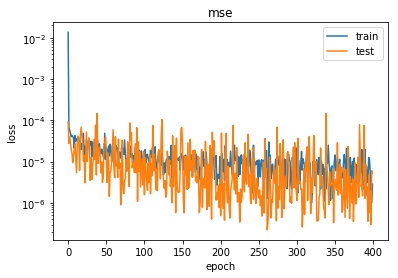

In [11]:
# loss
fig = plt.figure()
plt.semilogy(history.history['loss'])
if vsplit:
    plt.semilogy(history.history['val_loss'])
plt.title('mse')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# post processing

In [13]:
model.load_weights("./tmp/weights.best.hdf5")

#test_points = [0.6, 0.7, 0.8, 0.9, 1.]
test_points = [1.02, 1.05, 1.1, 1.2, 1.5]
rho_predict = []
rho_test = []
for x_p in test_points:
    T_P_test = np.append(T_test, np.ones((len(T_test), 1)) * (x_p - P_min) / (P_max - P_min), axis=1)
    predict = model.predict(T_P_test)
    rho_ref = np.asarray([CP.PropsSI('D', 'T', x_T, 'P', x_p * p_c, fluid) for x_T in T_vec])
    rho_ref = rhoTP_scaler.transform(rho_ref.reshape(-1, 1))

    rho_predict.append(predict)
    rho_test.append(rho_ref)

# rho plot

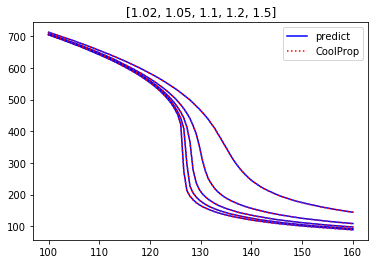

In [19]:
# 1.Plot actual vs prediction for training set
fig = plt.figure()
for prdt, ref in zip(rho_predict, rho_test):
    plt.plot(T_scaler.inverse_transform(T_test), rhoTP_scaler.inverse_transform(prdt), 'b-')
    plt.plot(T_scaler.inverse_transform(T_test), rhoTP_scaler.inverse_transform(ref), 'r:')
plt.legend(['predict', 'CoolProp'], loc='upper right')
plt.title(test_points)

# R2 accuracy

Training Set R-Square= 0.999996356213


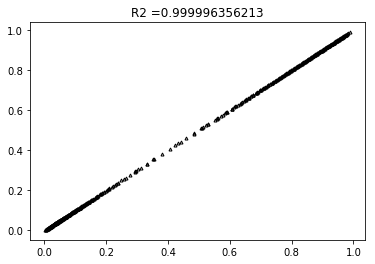

In [18]:
# 2.L2 accuracy plot
# Compute R-Square value for training set
from sklearn.metrics import r2_score

a = np.asarray(rho_predict).reshape(-1, 1)
b = np.asarray(rho_test).reshape(-1, 1)
TestR2Value = r2_score(a, b)
print("Training Set R-Square=", TestR2Value)

fig = plt.figure()
plt.plot(a, b, 'k^', ms=3, mfc='none')
plt.title('R2 ='+str(TestR2Value))